<a href="https://colab.research.google.com/github/carolyn-y6/GAN-Project/blob/main/GAN_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# !pip install --upgrade pip setuptools wheel
# !pip install tensorflow tensorflow-gpu matplotlib tensorflow-datasets ipywidgets
!pip install tensorflow matplotlib tensorflow-datasets ipywidgets
# how to import the pokemon dataset?

In [2]:
!pip list

Package                               Version
------------------------------------- -------------------
absl-py                               1.4.0
accelerate                            1.9.0
aiofiles                              24.1.0
aiohappyeyeballs                      2.6.1
aiohttp                               3.12.14
aiosignal                             1.4.0
alabaster                             1.0.0
albucore                              0.0.24
albumentations                        2.0.8
ale-py                                0.11.2
altair                                5.5.0
annotated-types                       0.7.0
antlr4-python3-runtime                4.9.3
anyio                                 4.9.0
anywidget                             0.9.18
argon2-cffi                           25.1.0
argon2-cffi-bindings                  21.2.0
array_record                          0.7.2
arviz                                 0.22.0
astropy                               7.1.0
astropy

In [3]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
for gpu in gpus:
    print(gpu)

In [5]:
import tensorflow_datasets as tfds #dont need if import photos from kaggle
from matplotlib import pyplot as plt

In [6]:
# load the fashion dataset from mnist. Probably want to import the pokemon one differently
ds = tfds.load('fashion_mnist',  split='train')

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.ZXTJYE_3.0.1/fashion_mnist-train.tfrecord*...:   …

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/incomplete.ZXTJYE_3.0.1/fashion_mnist-test.tfrecord*...:   0…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


In [7]:
# ds.as_numpy_iterator().next()['label']

In [8]:
import numpy as np

In [9]:
dataiterator = ds.as_numpy_iterator()

In [10]:
dataiterator.next() #getting data out of the pipeline

{'image': array([[[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 18],
         [ 77],
         [227],
         [227],
         [208],
         [210],
         [225],
         [216],
         [ 85],
         [ 32],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [ 61],
         [100],
         [ 97],
         [ 80],
         [ 57],
         [117],
         [227],
         [238],
         [115],
         [ 49],
         [ 78],
         [106],
         [108],
         [ 71],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0],
         [  0]],
 
        [[  0],
         [  0],
         [  0],
         [  0],
         [  0],
         

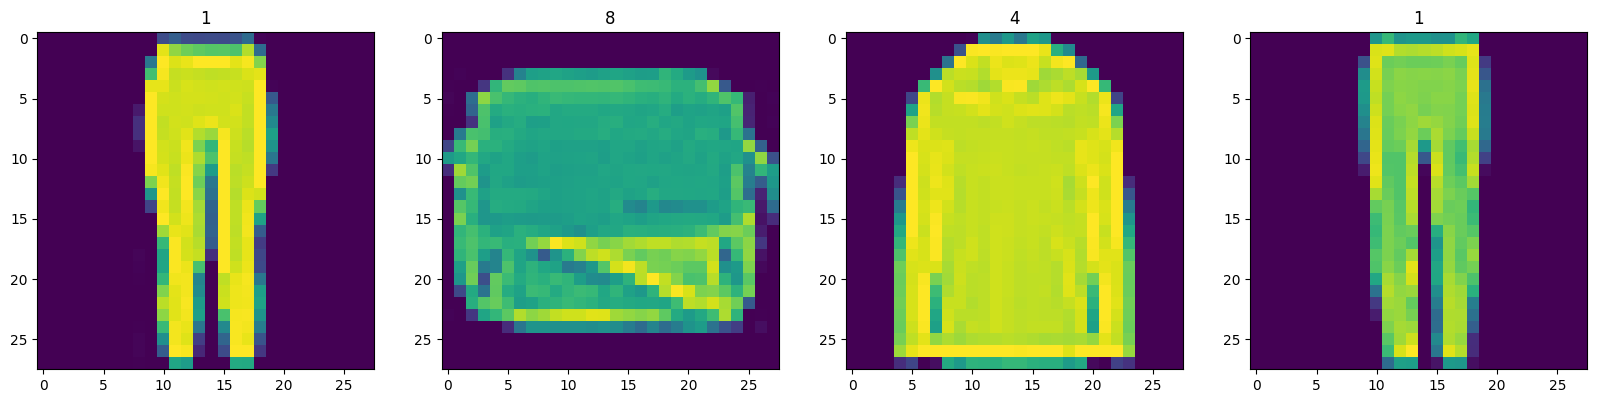

In [11]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20)) #set up subplot formatting. ax is each individual image, fig is the whole thing together (all 4 garments)
for idx in range(4): #loop 4 times and get images
    sample = dataiterator.next() #sample of the data. Get image + label
    ax[idx].imshow(np.squeeze(sample['image'])) #squeeze bc in a set of sub arrays. collapses the array, makes dimensions smaller
    ax[idx].title.set_text(sample['label']) #put image label as plot title

In [12]:
def scale_images(data): #takes data from tensorflow pipeline
  image = data['image'] #get the image only bc the data comes with image + labels
  return image / 255 #divide the image by 255 to get the

In [13]:
# the steps to build a pipeline in tensorflow
# map
# cache
# shuffle
# batch prefetch

In [14]:
ds = tfds.load('fashion_mnist', split='train') #reload the dataset
ds = ds.map(scale_images) #running the dataset through the scale_images preprocessing step
ds = ds.cache() #cache the dataset for the batch
ds = ds.shuffle(60800) #shuffle it up, the number if the shuffle buffer
ds = ds.batch(128) #128 is the number of images in the sample/batch
ds = ds.prefetch(64) #eliminates the likelyhood of bottlenecking


In [16]:
ds.as_numpy_iterator().next().shape #128 (number of images), 28 (pixels wide), 28 (pixels hight), 1 (indicates greyscale)

(128, 28, 28, 1)

In [17]:
# Bring in the sequential api for the generator and discriminator
from tensorflow.keras.models import Sequential
# Bring in the layers for the neural network
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

In [40]:
def build_generator():
  model = Sequential()
  #generate based on 128 random values (latent space) which is the input
  #then convert the latent space to a space of dimensions 7*7*128
  model.add(Dense(7 * 7 * 128, input_dim=128))
  #apply a leaklyrelu to account for non-linearities in the model. Output for the negative part is 0.2
  model.add(LeakyReLU(0.2))
  #take the dense input of the dimensions 7*7*128 and then output an image in the shape of the data (128, 28, 28, 1) as seen above
  model.add(Reshape((7,7,128)))

  # Upsampling block 1
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Upsampling block 2
  model.add(UpSampling2D())
  model.add(Conv2D(128, 5, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 1
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Convolutional block 2
  model.add(Conv2D(128, 4, padding='same'))
  model.add(LeakyReLU(0.2))

  # Conv layer to get to one channel
  model.add(Conv2D(1, 4, padding='same', activation='sigmoid')) # sigmoid to get numbers between 0, 1 to generate an image

  return model

In [44]:
generator = build_generator()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [45]:
generator.summary() # currently not in the right shape. Want to get the data into the shape of 28*28*1 to get an image

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 6272)           │       809,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_21 (LeakyReLU)      │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_6 (Reshape)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_15 (UpSampling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_22 (LeakyReLU)      │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_16 (UpSampling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 28, 28, 128)    │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_23 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_24 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 28, 28, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_25 (LeakyReLU)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 1)      │         2,049 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,155,137 (8.22 MB)

 Trainable params: 2,155,137 (8.22 MB)

 Non-trainable params: 0 (0.00 B)

In [47]:
img = generator.predict(np.random.randn(4, 128, 1)) #generate 4 image, pass 128 random numbers
img

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step


array([[[[0.49494344],
         [0.4982419 ],
         [0.49340606],
         ...,
         [0.49724436],
         [0.4984267 ],
         [0.49835166]],

        [[0.5018673 ],
         [0.5003283 ],
         [0.49556854],
         ...,
         [0.49545202],
         [0.49878252],
         [0.4988621 ]],

        [[0.50511074],
         [0.49941474],
         [0.49898666],
         ...,
         [0.48403886],
         [0.49482036],
         [0.500943  ]],

        ...,

        [[0.5004488 ],
         [0.5014202 ],
         [0.49877155],
         ...,
         [0.4945451 ],
         [0.4946031 ],
         [0.4993766 ]],

        [[0.5037545 ],
         [0.50107026],
         [0.5000792 ],
         ...,
         [0.498369  ],
         [0.49809125],
         [0.49974892]],

        [[0.5015156 ],
         [0.5008569 ],
         [0.49975118],
         ...,
         [0.49794388],
         [0.49880007],
         [0.5001064 ]]],


       [[[0.50323176],
         [0.49721605],
         [0.49

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step


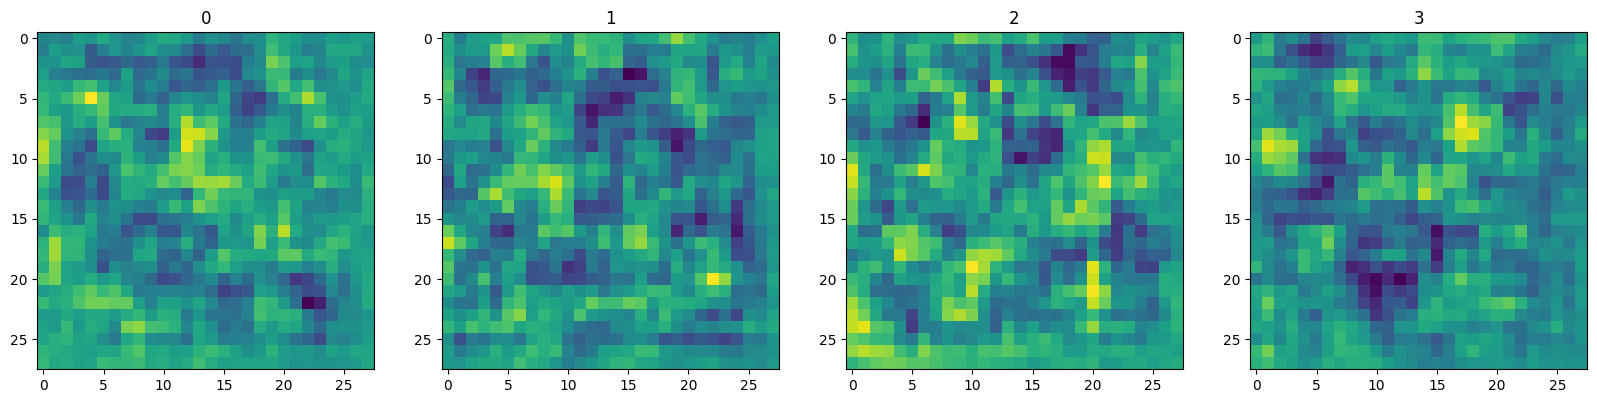

In [52]:
img = generator.predict(np.random.randn(4, 128, 1))
fig, ax = plt.subplots(ncols=4, figsize=(20, 20)) #set up subplot formatting. ax is each individual image, fig is the whole thing together (all 4 garments)
for idx, img in enumerate(img): #loop 4 times and get images
    ax[idx].imshow(np.squeeze(img)) #squeeze bc in a set of sub arrays. collapses the array, makes dimensions smaller
    ax[idx].title.set_text(idx) #put image label as plot title

In [ ]:
#Discriminator
def build_discriminator():
  model = Sequential()
  model.add(Conv2D(64, 5, input_shape=(28, 28, 1)))
  return model

In [ ]:
discriminator = build_discriminator()

In [ ]:
discriminator.summary()